In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%%bash

# convert transcripts to genes
extract_from_gtf.py -f genes -w transcript -o INTERMEDIATE_FILES/ \
/home/ferrari/ferrari/my_repository/annotations_gencode/mouse/M18/annotation_snakePipes/gencode.vM18.annotation.sorted.gtf

In [13]:
tr = pd.read_csv("INTERMEDIATE_FILES/genes.bed",sep="\t",index_col=7,header=None)
tr = tr[3].to_dict()
tr

{'ENSMUST00000193812.1': 'ENSMUSG00000102693.1',
 'ENSMUST00000082908.1': 'ENSMUSG00000064842.1',
 'ENSMUST00000162897.1': 'ENSMUSG00000051951.5',
 'ENSMUST00000159265.1': 'ENSMUSG00000051951.5',
 'ENSMUST00000070533.4': 'ENSMUSG00000051951.5',
 'ENSMUST00000192857.1': 'ENSMUSG00000102851.1',
 'ENSMUST00000195335.1': 'ENSMUSG00000103377.1',
 'ENSMUST00000192336.1': 'ENSMUSG00000104017.1',
 'ENSMUST00000194099.1': 'ENSMUSG00000103025.1',
 'ENSMUST00000161581.1': 'ENSMUSG00000089699.1',
 'ENSMUST00000192973.1': 'ENSMUSG00000103201.1',
 'ENSMUST00000192183.1': 'ENSMUSG00000103147.1',
 'ENSMUST00000195166.1': 'ENSMUSG00000103161.1',
 'ENSMUST00000192692.1': 'ENSMUSG00000102331.1',
 'ENSMUST00000193244.1': 'ENSMUSG00000102348.1',
 'ENSMUST00000194454.1': 'ENSMUSG00000102592.1',
 'ENSMUST00000157708.2': 'ENSMUSG00000088333.2',
 'ENSMUST00000194643.1': 'ENSMUSG00000102343.1',
 'ENSMUST00000192427.1': 'ENSMUSG00000102343.1',
 'ENSMUST00000208660.1': 'ENSMUSG00000025900.12',
 'ENSMUST0000019538

['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']
0 cluster_1
1 cluster_2
2 cluster_3
3 cluster_4
4 cluster_5


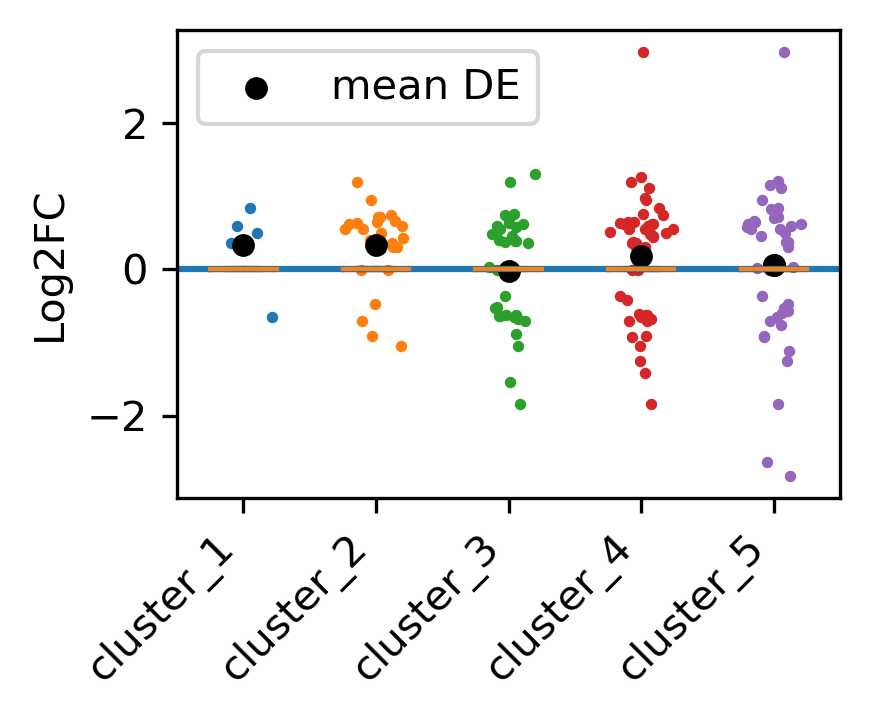

In [37]:
clusts = pd.read_csv("INTERMEDIATE_FILES/clusters_DG-CA_consensus.tsv", sep="\t")

annot = pd.read_csv("INTERMEDIATE_FILES/Homer_PeaksAnnotation_CA-DG_consensus.tsv", sep="\t")
annot["peakID"] = ["{}:{}-{}".format(annot["Chr"][i],annot["Start"][i]-1,annot["End"][i]) for i in annot.index]
annot["refAnnotationTr"] = [annot["Nearest PromoterID"][i] if not annot["Annotation"][i] == "Intergenic" else "Intergenic" for i in annot.index]
annot["refAnnotationGene"] = [tr[k] if k in tr else k for k in annot["refAnnotationTr"]]

clusts = clusts.merge(annot[["refAnnotationGene","peakID"]],how='right',left_on="name",right_on="peakID")
clusts = clusts.dropna()
# clusts["name"] = [str(k).split("_")[0] for k in clusts["name"].values]
exp = pd.read_csv("DESeq2/DE_genes_shrinked_apeglm.tsv",sep="\t")
clusts = clusts.merge(exp, how='right',left_on="refAnnotationGene", right_index=True).dropna()
clusts

input_data = []
fig,ax=plt.subplots(dpi=300,figsize=(3,2.5))
cls = sorted(clusts["deepTools_group"].unique())
print(cls)
for k,i in enumerate(cls):
    print(k,i)
    df_ = clusts.loc[clusts["deepTools_group"] == i].drop_duplicates(subset=["refAnnotationGene"])
    input_data.append(np.array(df_['log2FoldChange'].dropna().values))
    sigs = df_.loc[df_.padj<0.05]["log2FoldChange"].dropna()
#     input_data.append(sigs)
    ax.scatter(np.random.normal(0,0.1,size=len(sigs))+k+1, sigs, s=3)
    ax.scatter(k+1, np.mean(sigs), s=20,color='k')
    if k == 4:
        ax.scatter(k+1, np.mean(sigs), s=20,color='k',label='mean DE')
input_data

ax.boxplot(input_data, showfliers=False, )
ax.axhline(0)
plt.xticks(np.array(range(len(cls)))+1,cls, rotation=45,ha='right')
plt.legend()
plt.ylabel("Log2FC")

plt.tight_layout()
plt.savefig("FIGURES/DE_AnnotatedGenes_clusts_CA-DG.png")